In [ ]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#for model building
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score,precision_recall_curve,average_precision_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
df_original= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/onlinefraud.csv')
# df_original

In [3]:
#to save our original dataset as a copy
df=df_original.copy()

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


this give info about every column and the number of entries.

#Data preprocessing

In [7]:
#Check for missing values
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


 Its a good thing that there are no null values in our datasets.

Encoding Categorical Variables:

In [8]:

#as Machine learning models typically work with numerical data.
df["type"].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [9]:
df.isFlaggedFraud.value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [10]:
df.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

*   only 0.129% transactions are fraud .
*   Also only 16 transaction are flagged fraud.




In [11]:
df.type.value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

As we have already seen there are 5 types of payment happened. We'll now plot graph of types to see total amount transaction is by which type.

<Axes: xlabel='type'>

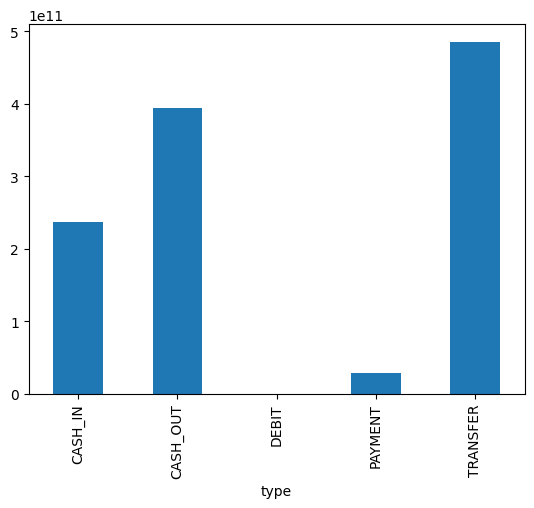

In [12]:
var = df.groupby('type').amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
var.plot(kind='bar')

In [13]:
df.loc[df.isFraud == 1].type.unique()


array(['TRANSFER', 'CASH_OUT'], dtype=object)

The graph above shows that TRANSFER and CASH_OUT are two most used mode of transaction and we can see that TRANSFER and CASH_OUT are also the only way in which fraud happen. Thus we will focus on this type of transactions.

In [14]:
#get one hot encoding of column type
one_hot = pd.get_dummies(df['type'])
#drop column type as it now encoded
df=df.drop('type',axis = 1)
#join the encoded df
df=df.join(one_hot)
#also we will drop cashin , debit and payment column as they are not related with fraud cases.
df=df.drop(['CASH_IN' , 'DEBIT', 'PAYMENT'],axis = 1)
df

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,False,False
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,False,False
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,False,True
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,True,False
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,True,False
6362616,743,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,False,True
6362617,743,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,True,False
6362618,743,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,False,True


In [15]:
df["nameOrig_type"]= df["nameOrig"].str[:1]
df["nameDest_type"]= df["nameDest"].str[:1]
#drop the columns as they are now encoded.
df = df.drop(["nameOrig", "nameDest"], axis=1)
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,TRANSFER,nameOrig_type,nameDest_type
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,False,False,C,M
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,False,False,C,M
2,1,181.00,181.00,0.00,0.00,0.00,1,0,False,True,C,C
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,True,False,C,C
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,False,False,C,M
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,0,True,False,C,C
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,0,False,True,C,C
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,True,False,C,C
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,0,False,True,C,C


In [16]:
df.nameOrig_type.value_counts()

nameOrig_type
C    6362620
Name: count, dtype: int64

Same for all , and do not provide any specific detail so we will drop it.

In [17]:
df = df.drop(["nameOrig_type"], axis=1)
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,TRANSFER,nameDest_type
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,False,False,M
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,False,False,M
2,1,181.00,181.00,0.00,0.00,0.00,1,0,False,True,C
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,True,False,C
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,False,False,M
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,0,True,False,C
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,0,False,True,C
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,True,False,C
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,0,False,True,C


In [18]:
df.loc[df.isFraud == 1].nameDest_type.unique()


array(['C'], dtype=object)

*  this also clear that only nameDest_type :"C" is related with fraud cases, so we will encode that also.



In [19]:
df.loc[df.isFlaggedFraud == 1].isFraud.unique()

array([1])

*   this shows that isflaggedfraud cases are also considered as fraud cases.

In [20]:
df=df.drop('isFlaggedFraud',axis=1)

In [21]:
#get one hot encoding of column type
one_hot = pd.get_dummies(df['nameDest_type'])
#drop column type as it now encoded
df=df.drop('nameDest_type',axis = 1)
#join the encoded df
df=df.join(one_hot)
df=df.drop(['M'],axis = 1)
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,TRANSFER,C
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,False,False,False
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,False,False,False
2,1,181.00,181.00,0.00,0.00,0.00,1,False,True,True
3,1,181.00,181.00,0.00,21182.00,0.00,1,True,False,True
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,True,False,True
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,False,True,True
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,True,False,True
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,False,True,True


#NORMALIZE FEATURES:

As there is lot of difference between max and min value in balance containing column so we will normalise them between range 0 to 1 for easy analysis.

In [22]:
def norm_column(df, column):
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
norm_cols=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
for i in norm_cols:
    norm_column(df,i)
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,TRANSFER,C
0,0.0,0.000106,0.002855,0.003233,0.000000,0.000000,0,False,False,False
1,0.0,0.000020,0.000357,0.000391,0.000000,0.000000,0,False,False,False
2,0.0,0.000002,0.000003,0.000000,0.000000,0.000000,1,False,True,True
3,0.0,0.000002,0.000003,0.000000,0.000059,0.000000,1,True,False,True
4,0.0,0.000126,0.000697,0.000603,0.000000,0.000000,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...
6362615,1.0,0.003674,0.005701,0.000000,0.000000,0.000954,1,True,False,True
6362616,1.0,0.068272,0.105923,0.000000,0.000000,0.000000,1,False,True,True
6362617,1.0,0.068272,0.105923,0.000000,0.000192,0.017912,1,True,False,True
6362618,1.0,0.009195,0.014265,0.000000,0.000000,0.000000,1,False,True,True


#CORRELATION BETWEEN COLUMNS:

<Axes: >

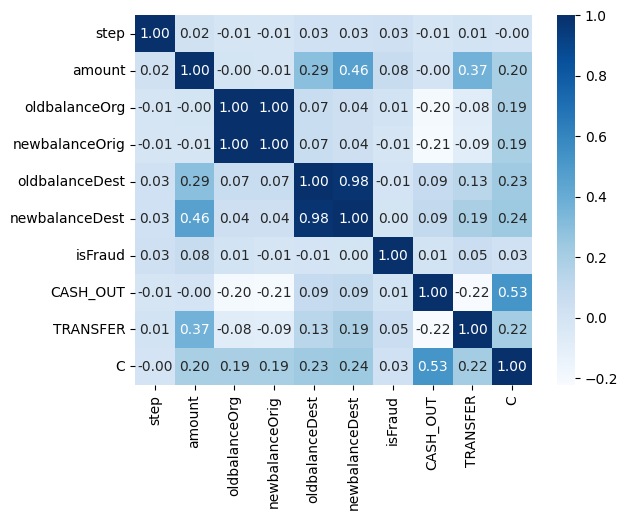

In [23]:
corr = df.corr() # plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap='Blues' ,fmt=".2f")

There is a high correlation between newbalanceOrig and oldbalanceOrg.

Also, between newbalanceDest and oldbalanceDest.

Apart from that, we have a relatively high correlation between amount and newbalanceDest and amount with oldbalanceDest.

Isfraud is very much correlated with amount.


In [24]:
df.loc[df["isFraud"] == 1,"isFraud"] = "is Fraud"
df.loc[df["isFraud"] == 0,"isFraud"] = "is Not Fraud"
df.loc[df["CASH_OUT"] == False,"CASH_OUT"] = 0.0
df.loc[df["CASH_OUT"] == True,"CASH_OUT"] = 1.0
df.loc[df["TRANSFER"] == False,"TRANSFER"] = 0.0
df.loc[df["TRANSFER"] == True,"TRANSFER"] = 1.0
df.loc[df["C"] == False,"C"] = 0.0
df.loc[df["C"] == True,"C"] = 1.0
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,TRANSFER,C
0,0.0,0.000106,0.002855,0.003233,0.000000,0.0,is Not Fraud,0.0,0.0,0.0
1,0.0,0.000020,0.000357,0.000391,0.000000,0.0,is Not Fraud,0.0,0.0,0.0
2,0.0,0.000002,0.000003,0.000000,0.000000,0.0,is Fraud,0.0,1.0,1.0
3,0.0,0.000002,0.000003,0.000000,0.000059,0.0,is Fraud,1.0,0.0,1.0
4,0.0,0.000126,0.000697,0.000603,0.000000,0.0,is Not Fraud,0.0,0.0,0.0


<Axes: xlabel='amount', ylabel='newbalanceDest'>

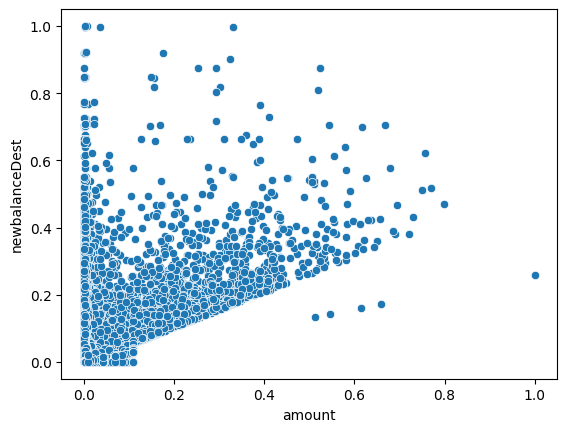

In [25]:
sns.scatterplot(x=df.amount, y=df.newbalanceDest)

#removal of outliers


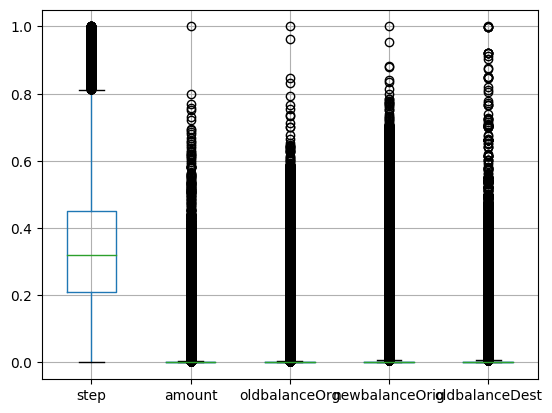

In [26]:
data=df[['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest']]
data.boxplot()
plt.show()

above graph shows that there are ouliers present which nedd to be removed.

removal of outliers by transformation method

In [27]:
num =[var for var in df.columns if df[var].dtype!='O' and var!='isFraud' and var!='CASH_OUT' and var!='TRANSFER' and var!='C']
num

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']

In [28]:
from scipy import stats
for x in num:
  bmi_z_score=stats.zscore(df[x])
  df=df[np.abs(bmi_z_score)<2]

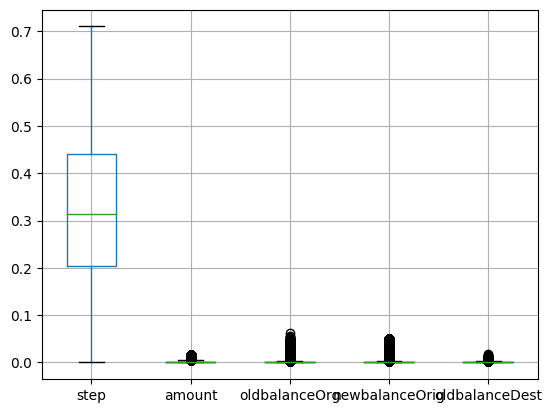

In [29]:
data=df[['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest']]
data.boxplot()
plt.show()

In [30]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,TRANSFER,C
0,0.0,0.000106,0.002855,0.003233,0.000000,0.0,is Not Fraud,0.0,0.0,0.0
1,0.0,0.000020,0.000357,0.000391,0.000000,0.0,is Not Fraud,0.0,0.0,0.0
2,0.0,0.000002,0.000003,0.000000,0.000000,0.0,is Fraud,0.0,1.0,1.0
3,0.0,0.000002,0.000003,0.000000,0.000059,0.0,is Fraud,1.0,0.0,1.0
4,0.0,0.000126,0.000697,0.000603,0.000000,0.0,is Not Fraud,0.0,0.0,0.0


#Undersampling

Building a sample dataset containing similar distribution of Non Fraudulent transactions and Fraudulent transactions. This rectifies the class-imbalance and helps our machine learning model to perform better predictions.

Since we want to build a model that detects Fraud, we base our sampling on the number of transactions classed as fraudulent in our original dataset.

In [31]:
# Sepearating Fraudulent transaction from non fraudulent

Fraudulent_Transaction = df[df.isFraud =="is Fraud"]
Not_Fraudulent_Transaction = df[df.isFraud =="is Not Fraud"]

In [32]:
print('Fraudulent Transaction: {}'.format(len(Fraudulent_Transaction)))
print('Not Fraudulent Transaction: {}'.format(len(Not_Fraudulent_Transaction)))


Fraudulent Transaction: 4098
Not Fraudulent Transaction: 5002051


In [33]:
Non_Fraudulent_Sample = Not_Fraudulent_Transaction.sample(n=len(Fraudulent_Transaction))


Joining the two dataframes

In [34]:
new_df = pd.concat([Non_Fraudulent_Sample, Fraudulent_Transaction], axis=0)


In [35]:
new_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,TRANSFER,C
3983663,0.400270,0.000361,0.000000,0.000000,0.002232,0.001750,is Not Fraud,1.0,0.0,1.0
4816269,0.464960,0.000017,0.000033,0.000009,0.000000,0.000004,is Not Fraud,1.0,0.0,1.0
3139220,0.316712,0.000040,0.000000,0.000000,0.002368,0.002378,is Not Fraud,1.0,0.0,1.0
75763,0.012129,0.000008,0.001162,0.001382,0.000000,0.000000,is Not Fraud,0.0,0.0,0.0
4616175,0.442049,0.001235,0.000184,0.000000,0.000953,0.001273,is Not Fraud,1.0,0.0,1.0


In [36]:
new_df['isFraud'].value_counts()


isFraud
is Not Fraud    4098
is Fraud        4098
Name: count, dtype: int64

In [37]:
#Checking to see if the new dataset we obtained is a good i.e does not deviate significantly from our original dataset
new_df.groupby('isFraud').mean()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_OUT,TRANSFER,C
isFraud,,,,,,,,,
is Fraud,0.347552,0.003903,0.006028,0.000013,0.000500,0.000987,0.479502,0.520498,1.0
is Not Fraud,0.303920,0.001312,0.001599,0.002111,0.001056,0.001290,0.373841,0.067838,0.590532


Now, the data can be split for training.

In [38]:
y = new_df['isFraud']
x = new_df.drop(['isFraud'], axis=1)

In [39]:
y.tail()

6117188    is Fraud
6117346    is Fraud
6117347    is Fraud
6117466    is Fraud
6117467    is Fraud
Name: isFraud, dtype: object

#Train test split

In [40]:
#using test size of 20%
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, stratify=y)


In [41]:
print('\n',x_train.head(2))

print('\n',x_test.head(2))

print('\n',y_train.head(2))

print('\n',y_test.head(2))


             step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
4104    0.002695  0.000114       0.000177        0.000000        0.000000   
687663  0.047170  0.000483       0.000017        0.000921        0.000201   

        newbalanceDest CASH_OUT TRANSFER    C  
4104          0.000030      1.0      0.0  1.0  
687663        0.000075      0.0      0.0  1.0  

              step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2342800  0.253369  0.000079       0.000112             0.0             0.0   
4758107  0.447439  0.000046       0.000000             0.0             0.0   

         newbalanceDest CASH_OUT TRANSFER    C  
2342800             0.0      0.0      0.0  0.0  
4758107             0.0      0.0      0.0  0.0  

 4104          is Fraud
687663    is Not Fraud
Name: isFraud, dtype: object

 2342800    is Not Fraud
4758107    is Not Fraud
Name: isFraud, dtype: object


#Training our classification model with a Logistic Regression Algorithm

In [42]:
model = LogisticRegression()
#training model with training data
model.fit(x_train, y_train)

LogisticRegression()

In [43]:
model_pred = model.predict(x_test)
# Obtain model probabilities
probs = model.predict_proba(x_test)

evaluation:

In [44]:
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

    is Fraud       0.70      0.93      0.79       820
is Not Fraud       0.89      0.60      0.71       820

    accuracy                           0.76      1640
   macro avg       0.79      0.76      0.75      1640
weighted avg       0.79      0.76      0.75      1640



In [45]:
# Print confusion matrix using predictions in context
pd.DataFrame(confusion_matrix(y_test, model_pred),
             columns=['Predicted Not Fraud(0) ', 'Predicted Fraud(1)'],
             index=['Actually Not Fraud(0)', 'Actually Fraud(1)'])

,Predicted Not Fraud(0),Predicted Fraud(1)
Actually Not Fraud(0),759,61
Actually Fraud(1),331,489


In [46]:
# ACCURACY SCORE
print('Accuracy:',accuracy_score(y_test, model_pred))

Accuracy: 0.7609756097560976


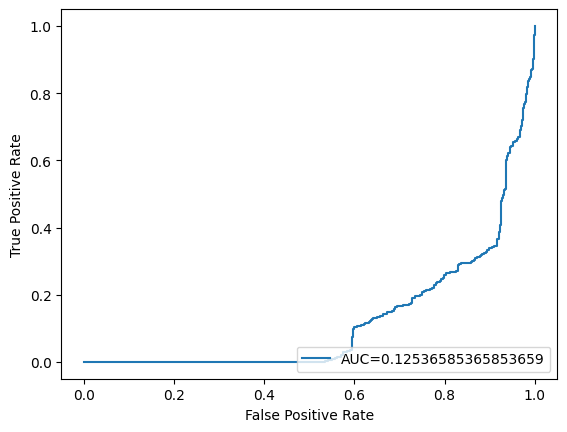

In [47]:
#define metrics
Y_pred_proba = model.predict_proba(x_test)[::,1]

# Map string labels in y_test to numerical labels
y_test_numeric = y_test.map({'is Not Fraud': 0, 'is Fraud': 1})

fpr, tpr, _ = metrics.roc_curve(y_test_numeric,  Y_pred_proba)  # Use numerical labels
auc = metrics.roc_auc_score(y_test_numeric, Y_pred_proba)  # Use numerical labels


#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [48]:
print('AUC Score:')
print(roc_auc_score(y_test, probs[:,1]))

AUC Score:
0.8746341463414633


#Training with Random Forest Classifier

In [49]:
# Defining the model as the random forest
model = RandomForestClassifier()

In [50]:
model.fit(x_train,y_train)


RandomForestClassifier()

In [51]:
model_pred = model.predict(x_test)

In [52]:
probs = model.predict_proba(x_test)

evaluation:

In [53]:
print('Classification_Report:\n',classification_report(y_test, model_pred))

Classification_Report:
               precision    recall  f1-score   support

    is Fraud       0.99      1.00      0.99       820
is Not Fraud       1.00      0.99      0.99       820

    accuracy                           0.99      1640
   macro avg       0.99      0.99      0.99      1640
weighted avg       0.99      0.99      0.99      1640



In [54]:
pd.DataFrame(confusion_matrix(y_test, model_pred),
             columns=['Predicted Not Fraud(0) ', 'Predicted Fraud(1)'],
             index=['Actually Not Fraud(0)', 'Actually Fraud(1)'])

,Predicted Not Fraud(0),Predicted Fraud(1)
Actually Not Fraud(0),816,4
Actually Fraud(1),9,811


In [55]:

# ACCURACY SCORE
print('Test Accuracy:',accuracy_score(y_test, model_pred))

Test Accuracy: 0.9920731707317073


In [56]:
#train test accuracy
model_test_pred=model.predict(x_train)
print('Train Accuracy:',accuracy_score(y_train, model_test_pred))

Train Accuracy: 1.0


In [57]:
# Convert string predictions to numerical values (assuming 'is Fraud' is positive)
model_pred_numeric = [1 if pred == 'is Fraud' else 0 for pred in model_pred]

# Calculate average precision using numerical predictions
average_precision = average_precision_score(y_test_numeric, model_pred_numeric)
print(average_precision)

0.9867050997782706


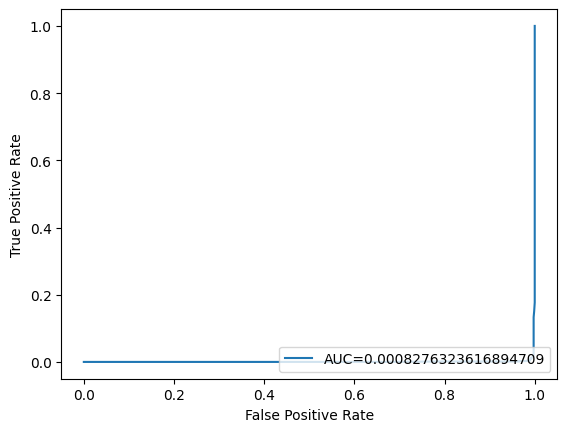

In [58]:
#define metrics
Y_pred_proba = model.predict_proba(x_test)[::,1]

# Convert y_test to numerical labels (assuming 'is Fraud' is positive)
y_test_numeric = [1 if label == 'is Fraud' else 0 for label in y_test]

fpr, tpr, _ = metrics.roc_curve(y_test_numeric,  Y_pred_proba) # Use numerical labels for y_test
auc = metrics.roc_auc_score(y_test_numeric, Y_pred_proba) # Use numerical labels for y_test


#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [59]:
# Print ROC_AUC score using probabilities
print('AUC Score:')
print(roc_auc_score(y_test, probs[:, 1]))

AUC Score:
0.9991723676383105


#Training with Xgboost classifier

In [60]:
!pip install --upgrade xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 1.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform

In [64]:
# Assuming 'is Fraud' is the positive class
y_train_numeric = [1 if label == 'is Fraud' else 0 for label in y_train]

# Convert object columns to numerical or categorical
for col in ['CASH_OUT', 'TRANSFER', 'C']:
    if x_train[col].dtype == 'object':
        # Attempt numerical conversion, handle errors as needed
        try:
            x_train[col] = x_train[col].astype(float)
        except:
            # If numerical conversion fails, treat as categorical
            x_train[col] = x_train[col].astype('category')

# Do the same conversions for x_test
for col in ['CASH_OUT', 'TRANSFER', 'C']:
    if x_test[col].dtype == 'object':
        # Attempt numerical conversion, handle errors as needed
        try:
            x_test[col] = x_test[col].astype(float)
        except:
            # If numerical conversion fails, treat as categorical
            x_test[col] = x_test[col].astype('category')

xgb1= xgb.XGBClassifier()
# Fit the XGBoost model with numerical labels
xgb1.fit(x_train, y_train_numeric)  # Enable categorical handling

# Predict on the test set
y_test_predict = xgb1.predict(x_test)

# Evaluate the model (ensure y_test is also numerical if needed)
test_accuracy = accuracy_score(y_test_numeric, y_test_predict)
print(test_accuracy)

0.9926829268292683


In [65]:
# Assuming 'is Fraud' is the positive class
y_test_numeric = [1 if label == 'is Fraud' else 0 for label in y_test]

print('Classification_Report:\n',classification_report(y_test_numeric, y_test_predict)) # Use y_test_numeric

Classification_Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       820
           1       0.99      0.99      0.99       820

    accuracy                           0.99      1640
   macro avg       0.99      0.99      0.99      1640
weighted avg       0.99      0.99      0.99      1640



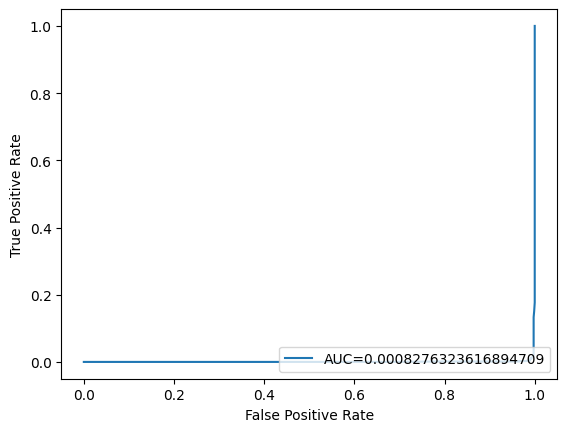

In [67]:
#define metrics
Y_pred_proba = model.predict_proba(x_test)[::,1]

# Convert y_test to numerical labels (assuming 'is Fraud' is positive)
y_test_numeric = [1 if label == 'is Fraud' else 0 for label in y_test]

fpr, tpr, _ = metrics.roc_curve(y_test_numeric,  Y_pred_proba) # Use numerical labels for y_test
auc = metrics.roc_auc_score(y_test_numeric, Y_pred_proba) # Use numerical labels for y_test


#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [68]:
# Print ROC_AUC score using probabilities
print('AUC Score:')
print(roc_auc_score(y_test, probs[:, 1]))

AUC Score:
0.9991723676383105


This model has give the highest accuracy and AUC score also. So we will consider this !!